<a href="https://colab.research.google.com/github/makanig/cnnClassification/blob/main/DMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade scikit-image
!apt-get -qq install -y libsm6 libxext6 
!pip install -q -U opencv-python


     |████████████████████████████████| 12.4MB 5.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
     |████████████████████████████████| 49.5MB 69kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns
%matplotlib inline
import pandas as pd
import os

In [ ]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [ ]:
training_folder_name = '/content/drive/MyDrive/Altemetrik/DMS/Raw'

# New location for the resized images
train_folder = '/content/drive/MyDrive/Altemetrik/DMS/Training'


# Create resized copies of all of the source images
size = (128,128)


# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
 
            file_path = os.path.join(root,sub_folder, file_name)
  
            image = Image.open(file_path)
       
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
       
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder Electricity Bill
processing folder DL
processing folder Passport
Done.


In [ ]:
classes = sorted(os.listdir(training_folder_name))
print(classes)

['DL', 'Electricity Bill', 'Passport']


In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.7.0+cu101


In [ ]:
def load_dataset(data_path):
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (75% and testing (25%) datasets)
    train_size = int(0.75 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 10-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=10,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 10-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=10,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader




In [ ]:
# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read /content/drive/MyDrive/Altemetrik/DMS/Training


In [ ]:
class Net(nn.Module):
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=3, bias=True)
)


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
 
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
   
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
  
        optimizer.zero_grad()
        
        output = model(data)
        
        # loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 90
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.135238
	Training batch 2 Loss: 6.500983
	Training batch 3 Loss: 0.876404
Training set: Average loss: 2.837542
Validation set: Average loss: 1.406992, Accuracy: 4/8 (50%)

Epoch: 2
	Training batch 1 Loss: 1.884001
	Training batch 2 Loss: 0.779567
	Training batch 3 Loss: 0.996710
Training set: Average loss: 1.220093
Validation set: Average loss: 1.044048, Accuracy: 3/8 (38%)

Epoch: 3
	Training batch 1 Loss: 0.799191
	Training batch 2 Loss: 0.642189
	Training batch 3 Loss: 0.602640
Training set: Average loss: 0.681340
Validation set: Average loss: 0.846654, Accuracy: 5/8 (62%)

Epoch: 4
	Training batch 1 Loss: 0.507524
	Training batch 2 Loss: 1.187573
	Training batch 3 Loss: 0.599328
Training set: Average loss: 0.764809
Validation set: Average loss: 1.234500, Accuracy: 3/8 (38%)

Epoch: 5
	Training batch 1 Loss: 0.331759
	Training batch 2 Loss: 0.670639
	Training batch 3 Loss: 0.546243
Training set: Average loss: 0.516213
Validation set:

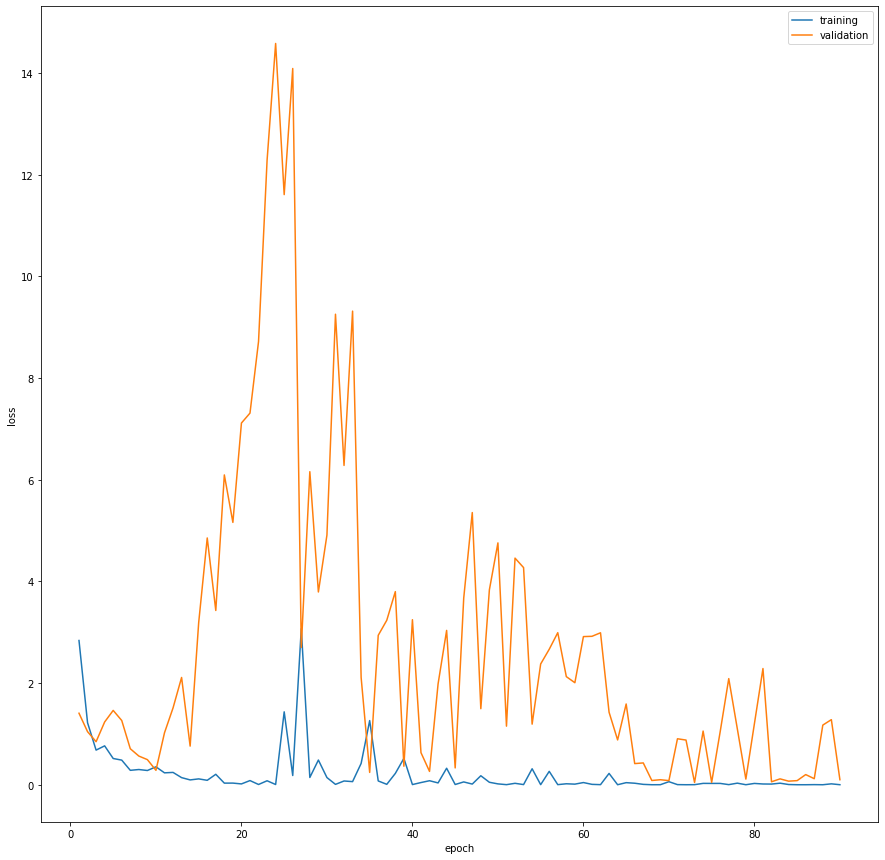

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


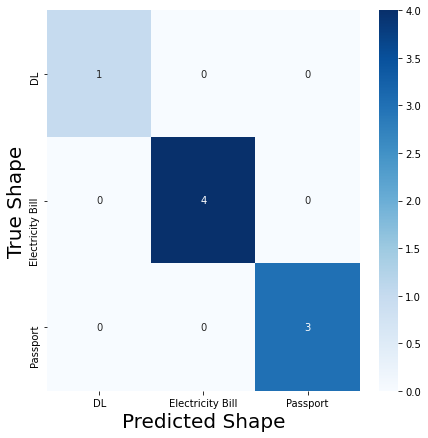

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

In [ ]:

from torch.autograd import Variable
loader = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


def image_loader(image):
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG
    return image 

In [ ]:
model(image_loader(inp))
#the model predicts class 3 as other values are negative.

tensor([[-30.2806, -33.7673,   0.0000]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
#the input image passinp.jpg is passed to the model
rawinp = Image.open('/content/drive/MyDrive/Altemetrik/DMS/passinp.jpg')
inp = resize_image(rawinp, size)
classes[np.argmax(model(image_loader(inp)).detach().numpy()[0])]
#the model classifies the image as a passport.

'Passport'

In [ ]:
#Saving the model
torch.save(model,'/content/drive/MyDrive/Altemetrik/DMS/Model/Dms_cnn.model')

In [ ]:
rawinp = Image.open('/content/drive/MyDrive/Altemetrik/DMS/passinp.jpg')
ip = resize_image(rawinp, size)

In [ ]:
#Loading the model
PATH = '/content/drive/MyDrive/Altemetrik/DMS/Model/Dms_cnn.model'
DMS_saved_model = torch.load(PATH)
DMS_saved_model.eval()

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=3, bias=True)
)

In [ ]:
classes[np.argmax(DMS_saved_model(image_loader(ip)).detach().numpy()[0])]

'Passport'